# (비지도학습) 고객 세분화 모델 구현
- 고객관리(CRM : Customer Relationship Management)의 RFM 분석
    - Recency(구매 최신성) : 얼마나 최근에 구매했는가?
    - Frequency(구매 빈도) : 얼마나 자주 구매했는가?
    - Monetary(구매 금액) : 얼마나 많은 금액을 지출했는가?

---
- 목표 : RFM 분석 기법을 이용하여 Customer segmentation을 어떻게 하는지 살펴보고, K-Means로 세분화 모델을 구현
- 데이터 출처 : https://archive.ics.uci.edu/dataset/502/online+retail+ii
- 데이터 설명
    - InvoiceNo : Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 
    - StockCode : Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 
    - Description : Product (item) name. Nominal. 
    - Quantity : The quantities of each product (item) per transaction. Numeric.	
    - InvoiceDate : Invice date and time. Numeric. The day and time when a transaction was generated. 
    - Price : Unit price. Numeric. Product price per unit in sterling (Â£). 
    - CustomerID : Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. 
    - Country : Country name. Nominal. The name of the country where a customer resides.

# 1.데이터 불러오기, 전처리

In [1]:
import datetime
import numpy as np
import datetime as dict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('./비지도학습_데이터/online_retail_II.xlsx', engine='openpyxl') # 엘셀 파일에서 데이터를 로드래서 데이터프레임으로 저장

df.head(20)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [3]:
df.describe()
# 수치데이터 컬럼 : Quantity, Price, Customer ID
# customer ID는 describe에 포함될 필요가 없음
# Quantity와 Price는 음수가 안오면 안되는데, 최소값이 음수임

,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


In [4]:
df.isnull().sum()
# Description(product name)과 Customer ID 두 컬럼에 결측치가 있음.

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [5]:
# quantity, Price의 음수값 제거하기
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# 중복 데이터 제거하기
df = df.drop_duplicates()

# 2.RFM 분석 기업을 이용한 고객 분류
- recency(구매 최신성) : 고객이 가장 최근에 트랜잭션을 수행한 이후 경과된 시간, 일단위로 측정
- frequency(구매 빈도) : 고객이 수행한 총 트랜잭션 수
- monetary(구매 금액) : 고객이 모든 거래에서 지출한 총 금액

## 2-1. RFM 값 계산
- 날짜컬럼.max() : 최신 날짜
- datetime.timedelta() : 두 날짜의 차이를 계산할 때 사용하는 함수이다. timedelta 객체에는 산술 연산자 +와 -를 사용할 수 있으므로 어떤 날짜에 원하는 기간(일, 시, 분, 초)을 더하거나 뺄 수 있다.
- nuniqye() : 데이터에 고유값들의 수를 출력해주는 함수

In [6]:
# 마지막 날짜의 다음날
last_date = df.InvoiceDate.max() + datetime.timedelta(days=1)

# 구매 수량과 제품 가격을 곱해서 구매 금액 계산하기
df['Amount'] = df['Price'] * df['Quantity'] 

# 고객별로 최근 구매 경과일, 구매 건수, 금액 합계 구학
rfm = df.groupby('Customer ID').agg( { 
                                      'InvoiceDate' : lambda InvoiceDate: (last_date - InvoiceDate.max()).days,
                                      'Invoice': lambda Invoice: Invoice.nunique(),
                                      'Amount': lambda Amount: Amount.sum()
                                     })

rfm.head()

,InvoiceDate,Invoice,Amount
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93


In [7]:
rfm.columns = ['recency', 'frequency', 'monetary']
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93


## 2-2. 고객 점수 계산
- 고객에 대해 구매 최신성, 구매 빈도, 구매 금액을 1~5로 환산하고
- 이를 모두 합하여 customer_score를 계산한다
- pandas.qcut() : 범위를 n개의 구간으로 나눈다.
- recency_score : 최신성이 적을수록 높은 점수
- frequency_score : 구매 빈도가 높을수록 높은 점수
- monetary_score : 구매 금액이 클수록 높은 점수

In [8]:
# 1-5점수로 환산
rfm['recency_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1]).astype(int)

rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
# rank(method='first) : ranks assigned in order they appear in the array

rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5]).astype(int)

In [9]:
# customer_score로 저장
rfm['customer_score'] = rfm['recency_score'] + rfm['frequency_score'] + rfm['monetary_score']

rfm.head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,customer_score
Customer ID,,,,,,,
12346.0,165,11,372.86,2,5,2,9
12347.0,3,2,1323.32,5,2,4,11
12348.0,74,1,222.16,2,1,1,4
12349.0,43,3,2671.14,3,3,5,11
12351.0,11,1,300.93,5,1,2,8
12352.0,11,2,343.80,5,2,2,9
12353.0,44,1,317.76,3,1,2,6
12355.0,203,1,488.21,1,1,2,4
12356.0,16,3,3560.30,4,3,5,12


## 2-3. customer score로 등급 분류하기

In [10]:
# 고객 점수가 15점 만점이면서 구매 금액 합계가 큰 순서대로 보기
rfm[rfm['customer_score'] == 15].sort_values(by='monetary', ascending=False)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,customer_score
Customer ID,,,,,,,
18102.0,1,89,349164.35,5,5,5,15
14646.0,10,78,248396.50,5,5,5,15
14156.0,7,102,196549.74,5,5,5,15
14911.0,1,205,152121.22,5,5,5,15
13694.0,9,94,131443.19,5,5,5,15
...,...,...,...,...,...,...,...
17732.0,8,8,2166.42,5,5,5,15
17552.0,8,10,2154.88,5,5,5,15
15059.0,12,10,2153.48,5,5,5,15


In [11]:
# 4등급(vip, gold, silver, white)로 분류하기
def level(score):
    if score > 12:
        return 'VIP'
    if 9 < score <= 12 :
        return 'GOLD'
    if 5 < score <= 9:
        return 'SILVER'
    else:
        return 'WHITE'
    
# level:고객 등급 컬럼 생성하기
rfm['level'] = rfm['customer_score'].apply(lambda x: level(x))
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,customer_score,level
Customer ID,,,,,,,,
12346.0,165,11,372.86,2,5,2,9,SILVER
12347.0,3,2,1323.32,5,2,4,11,GOLD
12348.0,74,1,222.16,2,1,1,4,WHITE
12349.0,43,3,2671.14,3,3,5,11,GOLD
12351.0,11,1,300.93,5,1,2,8,SILVER


<Axes: xlabel='level', ylabel='count'>

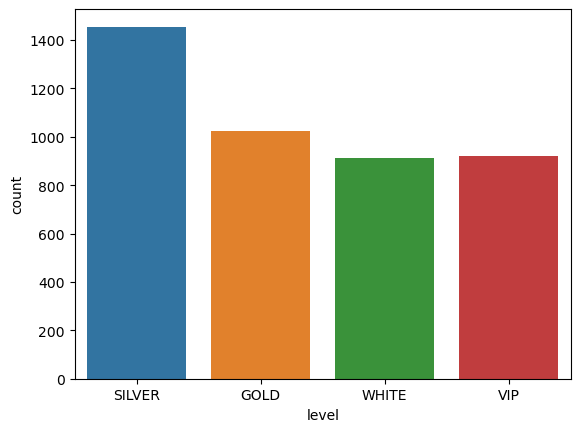

In [12]:
# 그래프로 시각화
sns.countplot(x = rfm['level'])

## 2-4. K-means 군집화 알고리즘을 이용한 고객 분류
- 구매 행동에 따른 고객 세분화를 기반으로 다양한 그룹을 식별하기 위해 비지도학습을 적용
- 전체 클러스터는 RFM을 기반으로 한다.

In [13]:
rfm.describe()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,customer_score
count,4312.000000,4312.000000,4312.000000,4312.000000,4312.000000,4312.000000,4312.000000
mean,91.171846,4.455705,2040.406712,3.024814,3.000000,3.000000,9.024814
std,96.860633,8.170213,8911.755977,1.424049,1.414706,1.414706,3.584884
min,1.000000,1.000000,2.950000,1.000000,1.000000,1.000000,3.000000
25%,18.000000,1.000000,307.187500,2.000000,2.000000,2.000000,6.000000
50%,53.000000,2.000000,701.615000,3.000000,3.000000,3.000000,9.000000
75%,136.000000,5.000000,1714.932500,4.000000,4.000000,4.000000,12.000000
max,374.000000,205.000000,349164.350000,5.000000,5.000000,5.000000,15.000000


#### 2-4-1. 이상치 제거

In [14]:
def processing_outlier(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)]
    return df

rfm_temp = rfm.copy()

Text(0.5, 1.0, 'After removing outliers in recency')

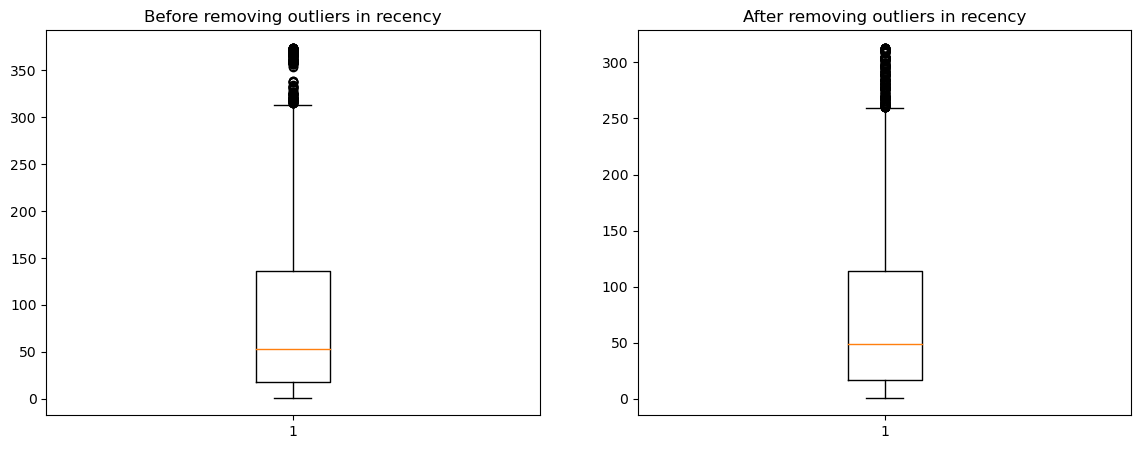

In [15]:
# recency 이상치 제거
rfm = processing_outlier(rfm, 'recency')

# 그래프로 비교
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.boxplot(rfm_temp.recency)
ax1.set_title('Before removing outliers in recency')
ax2.boxplot(rfm.recency)
ax2.set_title('After removing outliers in recency')

Text(0.5, 1.0, 'After removing outliers in frequency')

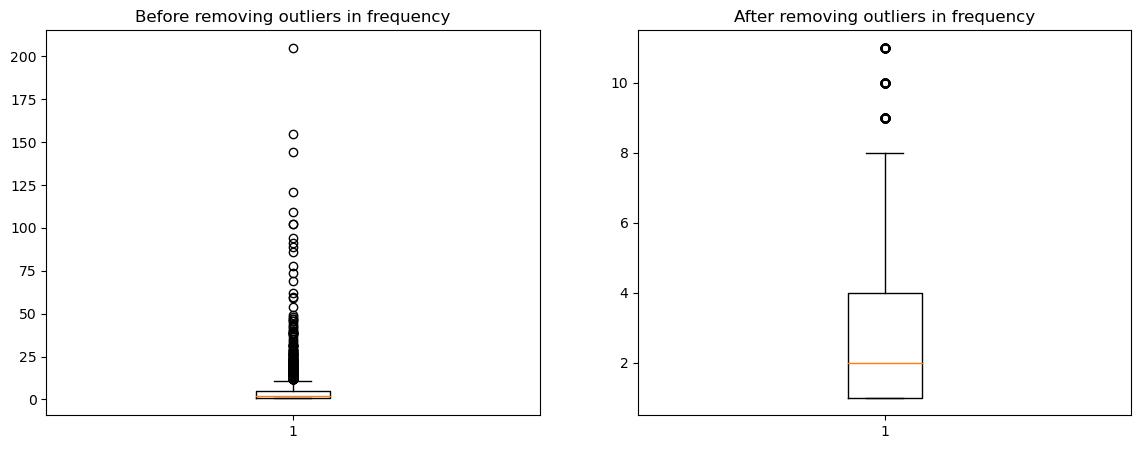

In [16]:

# frequency 이상치 제거
rfm = processing_outlier(rfm, 'frequency')

# 그래프로 비교
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.boxplot(rfm_temp.frequency)
ax1.set_title('Before removing outliers in frequency')
ax2.boxplot(rfm.frequency)
ax2.set_title('After removing outliers in frequency')


Text(0.5, 1.0, 'After removing outliers in monetary')

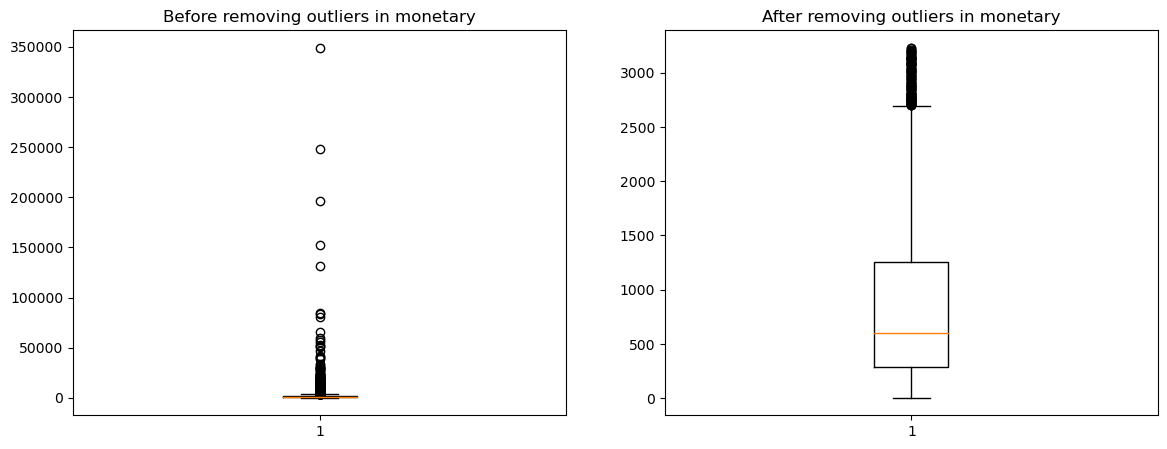

In [17]:
# monetary 이상치 제거
rfm = processing_outlier(rfm, 'monetary')

# 그래프로 비교
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.boxplot(rfm_temp.monetary)
ax1.set_title('Before removing outliers in monetary')
ax2.boxplot(rfm.monetary)
ax2.set_title('After removing outliers in monetary')


#### 2-4-2.표준화

In [18]:
rfm_k = rfm[['recency' ,'frequency' ,'monetary']]

# 표준화(0~1)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_k)

print(rfm_scaled)

[[ 0.9212283   3.66836645 -0.65156008]
 [-1.00622537 -0.39944379  0.61914885]
 [-0.16147716 -0.8514227  -0.85303709]
 ...
 [ 2.47984824 -0.8514227  -0.57917809]
 [ 0.2906416  -0.39944379  0.5831985 ]
 [-0.82775744  0.50451404  1.98602394]]


#### 2-4-4. clustering의 수 찾기

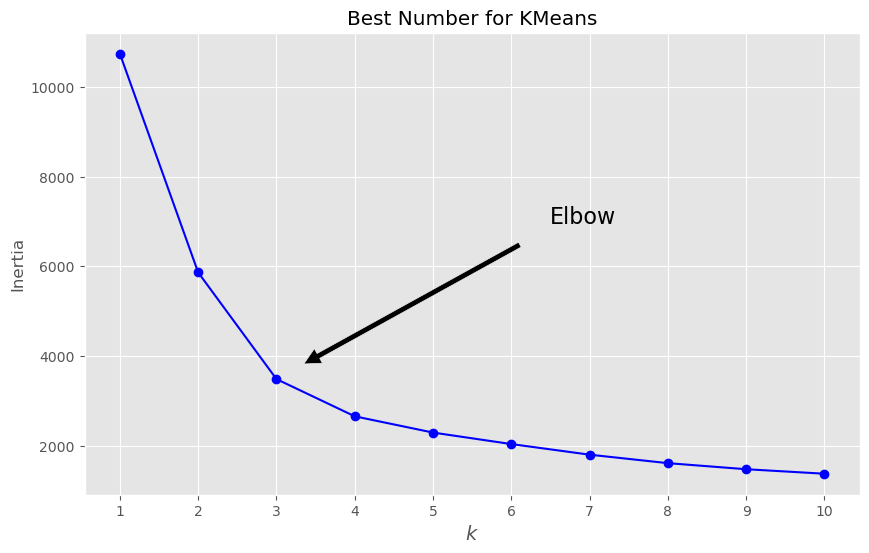

In [23]:
ks = range(1,11)
inertias = []

for k in ks:
    kc = KMeans(n_clusters=k, random_state=2023)
    kc.fit(rfm_scaled)
    cluster = kc.fit_predict(rfm_scaled)
    inertias.append(kc.inertia_)
    
plt.subplots(figsize=(10,6))
plt.plot(ks, inertias, 'bo-')
plt.xlabel('$k$', fontsize=14)
plt.ylabel('Inertia')
plt.annotate('Elbow', 
             xy=(3, inertias[2]), 
             xytext = (0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
            #  arrowprops=dict(facecolor='black', shrink=0.1), # 오류남
             arrowprops={'facecolor':'black', 'shrink':0.1},
            )
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('Best Number for KMeans')
plt.show()

#https://matplotlib.org/stable/gallery/text_labels_and_annotations/annotation_basic.html#sphx-glr-gallery-text-labels-and-annotations-annotation-basic-py 참고

# 결론
- RFM 분석 방법 + KMeans 클러스터링 2가지 방법을 결합하여 고객을 세분화할 수 있다
- 고객 세분화로 수익성이 높은 고객 그룹을 파악할 수 있다
- 이러한 AI 분석으로 어떤 고객 그룹에 특별 제안, 프로모션을 제공해야 하는지 알 수 있다.